In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!gdown 1lzmOPvwmzzWOfqLqK3gHPr4DFrKkyU34
!unzip dataset.zip

Downloading...
From (original): https://drive.google.com/uc?id=1lzmOPvwmzzWOfqLqK3gHPr4DFrKkyU34
From (redirected): https://drive.google.com/uc?id=1lzmOPvwmzzWOfqLqK3gHPr4DFrKkyU34&confirm=t&uuid=298ce5a8-a020-4b90-ad93-79afb784f751
To: /kaggle/working/dataset.zip
100%|████████████████████████████████████████| 464M/464M [00:05<00:00, 79.6MB/s]
Archive:  dataset.zip
   creating: dataset/
   creating: dataset/valid/
  inflating: __MACOSX/dataset/._valid  
   creating: dataset/test/
  inflating: __MACOSX/dataset/._test  
  inflating: dataset/data.yaml       
  inflating: __MACOSX/dataset/._data.yaml  
   creating: dataset/train/
  inflating: __MACOSX/dataset/._train  
   creating: dataset/valid/images/
  inflating: __MACOSX/dataset/valid/._images  
   creating: dataset/valid/labels/
  inflating: __MACOSX/dataset/valid/._labels  
   creating: dataset/test/images/
  inflating: __MACOSX/dataset/test/._images  
   creating: dataset/test/labels/
  inflating: __MACOSX/dataset/test/._labels  
  

In [3]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 89.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.8.93
    Uninstalling nvidia-nvjitlink-cu12-12.8.93:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.8.93
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.9.90
    Uninstalling nvidia-curand-cu12-10.3.9

In [4]:
from ultralytics import YOLO
from ultralytics.data.dataset import YOLODataset
import ultralytics.data.build as build
import numpy as np
import matplotlib.pyplot as plt
import cv2

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [5]:
class YOLOWeightedDataset(YOLODataset):
    def __init__(self, *args, mode="train", **kwargs):
        """
        Initialize the WeightedDataset.

        Args:
            class_weights (list or numpy array): A list or array of weights corresponding to each class.
        """

        super(YOLOWeightedDataset, self).__init__(*args, **kwargs)

        self.train_mode = "train" in self.prefix

        # You can also specify weights manually instead
        self.count_instances()
        class_weights = np.sum(self.counts) / self.counts
            
        # Aggregation function
        self.agg_func = np.mean            #Em đã test qua các np.max, np.sum, np.median, np.mean và thấy np.mean là đạt kết quả tốt nhất
    
        self.class_weights = np.array(class_weights)
        self.weights = self.calculate_weights()
        self.probabilities = self.calculate_probabilities()
    
    def count_instances(self):
        """
        Count the number of instances per class

        Returns:
            dict: A dict containing the counts for each class.
        """
        self.counts = [0 for i in range(len(self.data["names"]))]
        for label in self.labels:
            cls = label['cls'].reshape(-1).astype(int)
            for id in cls:
                self.counts[id] += 1

        self.counts = np.array(self.counts)
        self.counts = np.where(self.counts == 0, 1, self.counts)

    def calculate_weights(self):
        """
        Calculate the aggregated weight for each label based on class weights.

        Returns:
            list: A list of aggregated weights corresponding to each label.
        """
        weights = []
        for label in self.labels:
            cls = label['cls'].reshape(-1).astype(int)

            # Give a default weight to background class
            if cls.size == 0:
              weights.append(1)
              continue

            # Take mean of weights
            # You can change this weight aggregation function to aggregate weights differently
            weight = self.agg_func(self.class_weights[cls])
            weights.append(weight)
        return weights

    def calculate_probabilities(self):
        """
        Calculate and store the sampling probabilities based on the weights.

        Returns:
            list: A list of sampling probabilities corresponding to each label.
        """
        total_weight = sum(self.weights)
        probabilities = [w / total_weight for w in self.weights]
        return probabilities

    def __getitem__(self, index):
        """
        Return transformed label information based on the sampled index.
        """
        # Don't use for validation
        if not self.train_mode:
            return self.transforms(self.get_image_and_label(index))
        else:
            index = np.random.choice(len(self.labels), p=self.probabilities)
            return self.transforms(self.get_image_and_label(index))

In [6]:
import ultralytics.data.build as build

build.YOLODataset = YOLOWeightedDataset

In [7]:
# --- Bước 1: Load model pretrained YOLOv8n-seg
model = YOLO("yolov8m-seg.pt")  # Tải model nhẹ để fine-tune trên dataset của bạn

# --- Bước 2: Thiết lập các tham số huấn luyện
data_yaml = "/kaggle/working/dataset/data.yaml"          # File cấu hình dataset theo định dạng YOLO (hoặc COCO chuyển đổi)
epochs = 50                     # Số epoch tối đa (Early stopping sẽ dừng sớm nếu không cải thiện)
imgsz = 640                      # Kích thước ảnh đầu vào
batch_size = 16

100%|██████████| 52.4M/52.4M [00:00<00:00, 190MB/s]


In [8]:
results = model.train(
    data=data_yaml,
    batch=batch_size,
    epochs=epochs,
    imgsz=imgsz,
    copy_paste=0.3,
    copy_paste_mode='flip'
)

Ultralytics 8.3.131 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.3, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/dataset/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8m-seg.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, 

100%|██████████| 755k/755k [00:00<00:00, 18.2MB/s]


Overriding model.yaml nc=80 with nc=4

                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.conv.Conv             [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.block.C2f             [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.block.C2f             [192, 192, 4, True]           
  5                  -1  1    664320  ultralytics.nn.modules.conv.Conv             [192, 384, 3, 2]              
  6                  -1  4   3248640  ultralytics.nn.modules.block.C2f             [384, 384, 4, True]           
  7                  -1  1   1991808  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 75.6MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1718.8±697.1 MB/s, size: 66.7 KB)


train: Scanning /kaggle/working/dataset/train/labels... 5817 images, 44 backgrounds, 0 corrupt: 100%|██████████| 5817/5817 [00:05<00:00, 1004.56it/s]


train: New cache created: /kaggle/working/dataset/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 762.5±386.0 MB/s, size: 66.8 KB)


val: Scanning /kaggle/working/dataset/valid/labels... 238 images, 4 backgrounds, 0 corrupt: 100%|██████████| 238/238 [00:00<00:00, 701.70it/s]

val: New cache created: /kaggle/working/dataset/valid/labels.cache


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       1/50      9.59G      1.239      1.956      1.715       1.18        132        640: 100%|██████████| 364/364 [05:03<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.47it/s]

                   all        238       2478      0.462       0.54      0.443      0.264      0.455      0.532      0.431       0.22



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       2/50      8.71G      1.244      1.812      1.438      1.152        150        640: 100%|██████████| 364/364 [04:58<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.60it/s]

                   all        238       2478      0.543      0.519      0.515      0.298      0.542      0.515      0.511      0.257



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       3/50      8.53G      1.221      1.737      1.347       1.14        128        640: 100%|██████████| 364/364 [04:57<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.60it/s]

                   all        238       2478      0.475      0.537      0.508      0.315      0.471      0.527      0.493      0.257



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       4/50      8.58G      1.201      1.692      1.308      1.126        222        640: 100%|██████████| 364/364 [04:56<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.60it/s]

                   all        238       2478      0.583      0.518      0.538       0.33      0.589      0.508      0.532      0.269



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       5/50      8.75G      1.162      1.627      1.239      1.106        183        640: 100%|██████████| 364/364 [04:56<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.63it/s]

                   all        238       2478      0.604      0.548      0.587      0.366        0.6      0.545      0.581      0.309



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       6/50      8.64G       1.12       1.56      1.169       1.09        112        640: 100%|██████████| 364/364 [04:56<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.64it/s]

                   all        238       2478      0.616      0.569       0.61      0.374      0.618      0.568      0.601      0.311



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       7/50      9.72G      1.102      1.522      1.123      1.073        117        640: 100%|██████████| 364/364 [04:56<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.63it/s]

                   all        238       2478       0.62      0.602      0.628      0.396      0.618      0.614      0.632      0.337



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       8/50      8.56G      1.079      1.497      1.087      1.064        129        640: 100%|██████████| 364/364 [04:56<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.65it/s]

                   all        238       2478      0.603      0.592      0.614      0.396      0.619      0.577      0.614      0.326



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       9/50      8.53G      1.054      1.449      1.042       1.05        121        640: 100%|██████████| 364/364 [04:56<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.63it/s]

                   all        238       2478      0.643      0.583      0.631      0.407      0.644      0.581      0.619      0.332



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      10/50      8.59G      1.049      1.443      1.025      1.051        106        640: 100%|██████████| 364/364 [04:56<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.63it/s]

                   all        238       2478      0.589      0.617      0.624      0.402      0.595      0.615      0.625      0.346



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      11/50      8.59G      1.027        1.4      0.998      1.042        163        640: 100%|██████████| 364/364 [04:56<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.62it/s]

                   all        238       2478      0.597      0.604      0.604      0.382      0.593      0.596      0.595      0.314



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      12/50      8.59G      1.018      1.389     0.9771      1.038        140        640: 100%|██████████| 364/364 [04:56<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.63it/s]

                   all        238       2478      0.644      0.634      0.653      0.419      0.653      0.632      0.649       0.36



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      13/50      9.49G      1.004      1.363      0.945      1.029        201        640: 100%|██████████| 364/364 [04:56<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.64it/s]

                   all        238       2478      0.646      0.638      0.669      0.438      0.644      0.631       0.66      0.369



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      14/50      9.45G     0.9867      1.332     0.9259      1.019        133        640: 100%|██████████| 364/364 [04:56<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.66it/s]

                   all        238       2478      0.641      0.627      0.663      0.428      0.648      0.623      0.661      0.359



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      15/50      9.42G     0.9699      1.309     0.8849      1.012        130        640: 100%|██████████| 364/364 [04:56<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.63it/s]

                   all        238       2478      0.641      0.649      0.653      0.417      0.644      0.653      0.651      0.353



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      16/50      9.39G     0.9829      1.328     0.9038      1.014        120        640: 100%|██████████| 364/364 [04:56<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.66it/s]

                   all        238       2478      0.659      0.627       0.67      0.436       0.66      0.638      0.676      0.373



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      17/50       8.6G     0.9664      1.297     0.8653      1.004        213        640: 100%|██████████| 364/364 [04:56<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.64it/s]

                   all        238       2478      0.686      0.612      0.673       0.44      0.678      0.612      0.665      0.372



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      18/50      9.73G     0.9564      1.285     0.8547     0.9994        127        640: 100%|██████████| 364/364 [04:56<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.65it/s]

                   all        238       2478      0.631      0.649      0.652      0.431      0.632      0.649      0.645      0.358



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      19/50      9.73G     0.9379      1.269     0.8257      0.993         97        640: 100%|██████████| 364/364 [04:56<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.65it/s]

                   all        238       2478      0.646      0.629      0.662      0.434      0.646      0.633      0.659      0.369



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      20/50      8.51G     0.9228      1.235     0.8039     0.9859        211        640: 100%|██████████| 364/364 [04:56<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.67it/s]

                   all        238       2478      0.674      0.625      0.663      0.432      0.679      0.625      0.664      0.369



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      21/50      9.64G     0.9173      1.237     0.7946     0.9868        125        640: 100%|██████████| 364/364 [04:56<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.67it/s]

                   all        238       2478      0.667      0.621      0.668      0.435      0.648      0.641      0.663      0.365



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      22/50      8.51G     0.9159      1.232     0.7891     0.9817        235        640: 100%|██████████| 364/364 [04:56<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.67it/s]

                   all        238       2478      0.694      0.621      0.676       0.44      0.689      0.618      0.664      0.369



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      23/50      9.88G     0.8976      1.205     0.7591     0.9777        199        640: 100%|██████████| 364/364 [04:56<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.67it/s]

                   all        238       2478      0.663      0.609      0.658      0.429      0.658      0.617      0.657      0.359



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      24/50      8.55G     0.9054      1.219     0.7539     0.9718        176        640: 100%|██████████| 364/364 [04:56<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.68it/s]

                   all        238       2478      0.672      0.639      0.671      0.444      0.673       0.64      0.667      0.367



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      25/50      8.51G     0.8865      1.187     0.7296     0.9669         93        640: 100%|██████████| 364/364 [04:56<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.68it/s]

                   all        238       2478      0.665       0.63      0.645      0.425      0.667      0.629      0.642      0.359



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      26/50      8.51G     0.8803      1.178     0.7195     0.9616        153        640: 100%|██████████| 364/364 [04:56<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.69it/s]

                   all        238       2478      0.682      0.622      0.663      0.439      0.694      0.624      0.663      0.372



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      27/50      9.84G     0.8744      1.178     0.7109     0.9591        169        640: 100%|██████████| 364/364 [04:56<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.68it/s]

                   all        238       2478      0.669      0.629      0.659      0.437      0.675      0.619       0.65      0.362



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      28/50      8.51G     0.8628      1.143     0.6907      0.957        170        640: 100%|██████████| 364/364 [04:56<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.67it/s]

                   all        238       2478      0.672      0.643      0.672      0.442      0.673      0.645      0.669      0.369



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      29/50      8.82G     0.8512      1.137     0.6737     0.9523        124        640: 100%|██████████| 364/364 [04:56<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.69it/s]

                   all        238       2478      0.679      0.642      0.666      0.439      0.678       0.64      0.655      0.365



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      30/50      8.79G     0.8389      1.122     0.6587      0.944        117        640: 100%|██████████| 364/364 [04:56<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.67it/s]

                   all        238       2478      0.661      0.647      0.672       0.44      0.686      0.628      0.669      0.373



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      31/50      9.78G     0.8441      1.119     0.6593     0.9484        120        640: 100%|██████████| 364/364 [04:56<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.68it/s]

                   all        238       2478      0.673      0.643      0.671      0.445      0.686       0.64      0.675      0.373



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      32/50      8.65G      0.827      1.103     0.6279     0.9361        140        640: 100%|██████████| 364/364 [04:56<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.68it/s]

                   all        238       2478      0.675       0.62      0.655      0.433      0.695      0.617      0.655      0.362



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      33/50      9.75G     0.8217      1.099     0.6283     0.9369        183        640: 100%|██████████| 364/364 [04:56<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.68it/s]

                   all        238       2478      0.691      0.632      0.671      0.447      0.694      0.628      0.669      0.375



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      34/50      9.73G     0.8161      1.087     0.6195     0.9359        252        640: 100%|██████████| 364/364 [04:56<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.69it/s]

                   all        238       2478      0.696      0.623      0.661      0.441      0.706      0.615      0.663      0.373



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      35/50      8.56G     0.8137      1.091     0.6105     0.9325        134        640: 100%|██████████| 364/364 [04:56<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.66it/s]

                   all        238       2478      0.683      0.639      0.661      0.439      0.682      0.636      0.657      0.365



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      36/50      9.69G     0.8002      1.069     0.5987     0.9272         99        640: 100%|██████████| 364/364 [04:57<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.68it/s]

                   all        238       2478      0.697      0.636      0.671      0.443      0.701      0.637      0.674      0.377



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      37/50      9.83G     0.7945      1.061     0.5852     0.9221        169        640: 100%|██████████| 364/364 [04:56<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.68it/s]

                   all        238       2478      0.669      0.652      0.656      0.434      0.669      0.653      0.654      0.367



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      38/50      8.47G     0.7863       1.05     0.5745     0.9212        154        640: 100%|██████████| 364/364 [04:56<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.69it/s]

                   all        238       2478      0.686      0.647      0.659      0.434      0.689      0.644      0.657      0.366



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      39/50       9.8G     0.7862      1.053     0.5674     0.9195        135        640: 100%|██████████| 364/364 [04:56<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.69it/s]

                   all        238       2478      0.679      0.643      0.661      0.435      0.678      0.643      0.658      0.368



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      40/50      8.43G     0.7735      1.035     0.5591     0.9159        163        640: 100%|██████████| 364/364 [04:56<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.69it/s]

                   all        238       2478      0.669      0.638       0.66      0.438      0.666      0.636      0.656      0.367


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      41/50      8.44G     0.8327       1.12     0.5406     0.9353         96        640: 100%|██████████| 364/364 [04:54<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.69it/s]

                   all        238       2478       0.69      0.637      0.665      0.442      0.691      0.633       0.66      0.374



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      42/50      8.44G     0.8136      1.087     0.5045     0.9269         77        640: 100%|██████████| 364/364 [04:53<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.69it/s]

                   all        238       2478      0.665      0.643      0.656      0.437      0.697      0.617      0.657       0.37



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      43/50      8.41G     0.8007      1.077     0.4877       0.92         97        640: 100%|██████████| 364/364 [04:53<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.67it/s]

                   all        238       2478      0.694      0.604      0.661      0.441      0.698      0.597      0.657      0.372



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      44/50      8.38G     0.7797      1.059     0.4768     0.9137         58        640: 100%|██████████| 364/364 [04:53<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.70it/s]

                   all        238       2478       0.68      0.646      0.659       0.44      0.679      0.644      0.656      0.366



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      45/50      8.38G     0.7759      1.059     0.4724     0.9114         79        640: 100%|██████████| 364/364 [04:53<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.70it/s]

                   all        238       2478      0.729      0.599       0.66       0.44      0.725      0.596      0.655      0.373



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      46/50      8.38G     0.7607      1.026     0.4508      0.906         84        640: 100%|██████████| 364/364 [04:53<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.71it/s]

                   all        238       2478      0.706      0.625      0.662      0.443      0.711      0.623      0.668      0.377



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      47/50      8.38G     0.7589      1.022     0.4479     0.9046         75        640: 100%|██████████| 364/364 [04:53<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.70it/s]

                   all        238       2478      0.688      0.639      0.658      0.442      0.731       0.61      0.661       0.37



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      48/50      9.37G     0.7413       1.02     0.4356     0.8984         69        640: 100%|██████████| 364/364 [04:53<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.70it/s]

                   all        238       2478      0.692      0.621       0.66      0.443      0.698      0.623      0.661      0.374



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      49/50      9.37G     0.7335      1.005     0.4211     0.8955         59        640: 100%|██████████| 364/364 [04:53<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.70it/s]

                   all        238       2478      0.697       0.63      0.663      0.443      0.703      0.627      0.662      0.373



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      50/50      9.36G     0.7286      1.002     0.4269     0.8945         62        640: 100%|██████████| 364/364 [04:53<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.69it/s]

                   all        238       2478       0.71      0.616       0.66      0.443      0.718       0.62      0.664      0.374



50 epochs completed in 4.201 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics 8.3.131 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv8m-seg summary (fused): 105 layers, 27,224,700 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/8 [00:00<?, ?it/s]

WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  12%|█▎        | 1/8 [00:00<00:05,  1.37it/s]

WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  25%|██▌       | 2/8 [00:02<00:08,  1.46s/it]

WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:10<00:00,  1.35s/it]


                   all        238       2478      0.692      0.632      0.671      0.447      0.692       0.63      0.669      0.376
   grain discoloration         45        174      0.821      0.649      0.749      0.482      0.822      0.649      0.752      0.424
           leaf blight        174        778      0.623      0.568       0.58      0.428      0.628       0.57      0.586      0.343
     pesticide residue         37        727      0.619      0.701      0.685      0.496      0.636      0.713      0.699       0.45
            rice blast        152        799      0.705      0.609      0.671      0.381      0.683      0.587      0.639      0.286


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.3ms preprocess, 13.4ms inference, 0.0ms loss, 3.2ms postprocess per image
Results saved to runs/segment/train


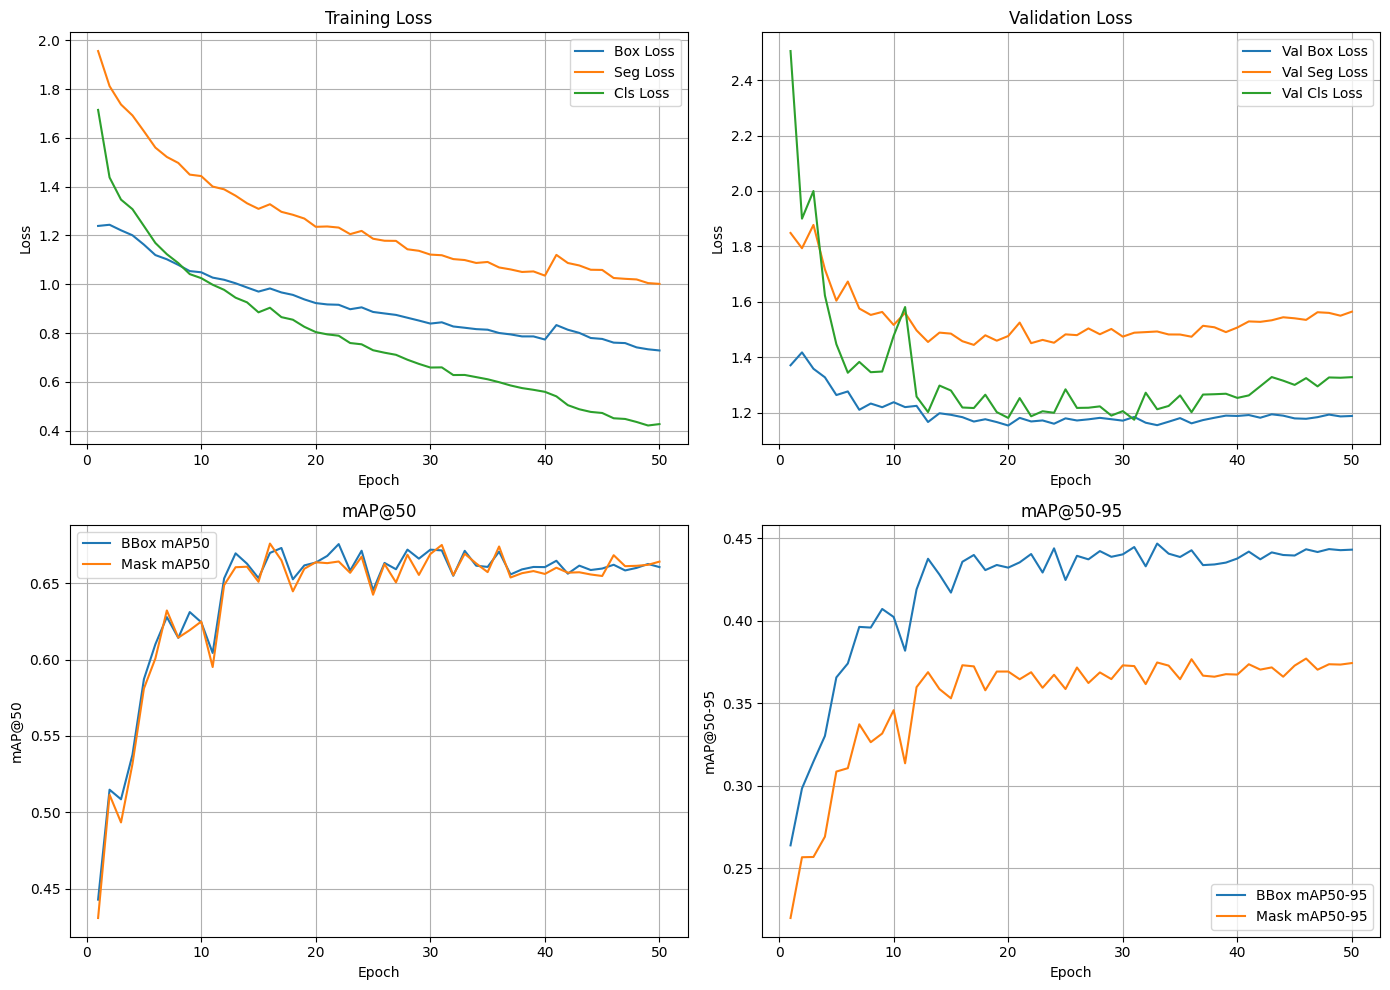

In [9]:
import pandas as pd

# Load lại file sau khi reset
file_path = "/kaggle/working/runs/segment/train/results.csv"
df = pd.read_csv(file_path)

import matplotlib.pyplot as plt

# Vẽ biểu đồ loss và mAP để đánh giá quá trình train
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# --- Training Loss ---
axes[0, 0].plot(df['epoch'], df['train/box_loss'], label='Box Loss')
axes[0, 0].plot(df['epoch'], df['train/seg_loss'], label='Seg Loss')
axes[0, 0].plot(df['epoch'], df['train/cls_loss'], label='Cls Loss')
axes[0, 0].set_title('Training Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True)

# --- Validation Loss ---
axes[0, 1].plot(df['epoch'], df['val/box_loss'], label='Val Box Loss')
axes[0, 1].plot(df['epoch'], df['val/seg_loss'], label='Val Seg Loss')
axes[0, 1].plot(df['epoch'], df['val/cls_loss'], label='Val Cls Loss')
axes[0, 1].set_title('Validation Loss')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True)

# --- mAP50 ---
axes[1, 0].plot(df['epoch'], df['metrics/mAP50(B)'], label='BBox mAP50')
axes[1, 0].plot(df['epoch'], df['metrics/mAP50(M)'], label='Mask mAP50')
axes[1, 0].set_title('mAP@50')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('mAP@50')
axes[1, 0].legend()
axes[1, 0].grid(True)

# --- mAP50-95 ---
axes[1, 1].plot(df['epoch'], df['metrics/mAP50-95(B)'], label='BBox mAP50-95')
axes[1, 1].plot(df['epoch'], df['metrics/mAP50-95(M)'], label='Mask mAP50-95')
axes[1, 1].set_title('mAP@50-95')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('mAP@50-95')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

In [10]:
%%!
zip -r train_weight_dataloader.zip /kaggle/working/runs/segment/train

['  adding: kaggle/working/runs/segment/train/ (stored 0%)',
 '  adding: kaggle/working/runs/segment/train/BoxPR_curve.png (deflated 10%)',
 '  adding: kaggle/working/runs/segment/train/BoxP_curve.png (deflated 8%)',
 '  adding: kaggle/working/runs/segment/train/val_batch1_pred.jpg (deflated 2%)',
 '  adding: kaggle/working/runs/segment/train/weights/ (stored 0%)',
 '  adding: kaggle/working/runs/segment/train/weights/last.pt (deflated 8%)',
 '  adding: kaggle/working/runs/segment/train/weights/best.pt (deflated 8%)',
 '  adding: kaggle/working/runs/segment/train/MaskR_curve.png (deflated 10%)',
 '  adding: kaggle/working/runs/segment/train/MaskPR_curve.png (deflated 9%)',
 '  adding: kaggle/working/runs/segment/train/MaskP_curve.png (deflated 8%)',
 '  adding: kaggle/working/runs/segment/train/val_batch0_labels.jpg (deflated 4%)',
 '  adding: kaggle/working/runs/segment/train/results.png (deflated 7%)',
 '  adding: kaggle/working/runs/segment/train/MaskF1_curve.png (deflated 10%)',
 '

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

def verify_class_balance(dataset, num_samples=1000):
    """
    Verifies whether the __getitem__ method in the YOLOWeightedDataset class returns a balanced class output.

    Args:
        dataset: An instance of YOLOWeightedDataset.
        num_samples: Number of samples to draw from the dataset.

    Returns:
        class_counts: A dictionary containing the class counts.
    """
    all_labels = []
    num_samples = min(len(dataset.labels), num_samples)

    if dataset.train_mode:
        choices = np.random.choice(len(dataset.labels), size=num_samples, p=dataset.probabilities)
    else:
        choices = np.random.choice(len(dataset.labels), size=num_samples, replace=False)

    for i in choices:
        label = dataset.labels[i]["cls"]
        all_labels.extend(label.reshape(-1).astype(int))

    class_counts = Counter(all_labels)
    return class_counts

def plot_class_balance(weighted_cnts, unweighted_cnts, class_names):
    """
    Plots the comparison of class distribution between training and validation modes.

    Args:
        weighted_cnts: A dictionary containing the class counts in weighted mode.
        unweighted_cnts: A dictionary containing the class counts in unweighted mode.
        class_names: A list of class names.
    """
    classes = range(len(class_names))
    weighted_values = [weighted_cnts.get(c, 0) for c in classes]
    unweighted_values = [unweighted_cnts.get(c, 0) for c in classes]

    width = 0.35  # Bar width

    fig, ax = plt.subplots()
    ax.bar(classes, unweighted_values, width, label='Normal mode')
    ax.bar([c + width for c in classes], weighted_values, width, label='Weighted Mode')

    ax.set_xlabel('Class')
    ax.set_ylabel('Count')
    ax.set_title('Class Distribution in Normal vs Weighted Modes')
    ax.set_xticks([c + width / 2 for c in classes])
    ax.set_xticklabels(class_names, rotation=45, ha='right')
    ax.legend()

    plt.show()

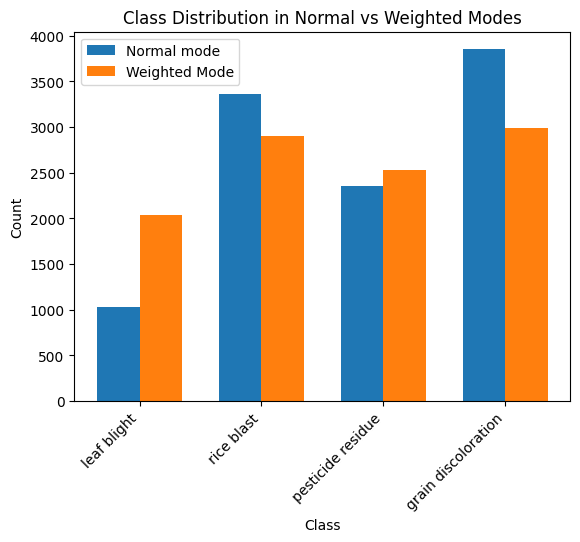

In [12]:
# You can test different aggregation functions np.max, np.sum, np.median, np.mean
model.trainer.train_loader.dataset.agg_func = np.mean
model.trainer.train_loader.dataset.weights = model.trainer.train_loader.dataset.calculate_weights()
model.trainer.train_loader.dataset.probabilities = model.trainer.train_loader.dataset.calculate_probabilities()

# Get class counts in weighted mode
model.trainer.train_loader.dataset.train_mode = True
weighted_counts = verify_class_balance(model.trainer.train_loader.dataset, num_samples=1000)

# Get class counts in default mode
model.trainer.train_loader.dataset.train_mode = False
default_counts = verify_class_balance(model.trainer.train_loader.dataset, num_samples=1000)

# Plot the comparison
plot_class_balance(weighted_counts, default_counts, set(model.trainer.train_loader.dataset.data["names"].values()))